# Something you'll actually use: Gradient Boosting machines
From user point of view the competing toolkits are largely the same. Think BMW vs. Mercedes or Tensorflow 2 vs pytorch. In each there is clever engeneering, smart algorithm enchantments and ingenious heuristic tricks, but for common tasks the performance difference is different from paper to paper and is small for practical purposes.

They all support **multithreading**, training on **GPU**,  have commited developer communities, **documentation**, and, subjectively, are great pieces of software. As of 2020 in chronological order:

### XGBoost
* Is the oldest and the most known
* Multi-node Multi-GPU distributed training
* Can [plot its trees](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting)

#### Notable technical details [[paper](https://arxiv.org/pdf/1603.02754.pdf)]:
* Can use [DART: Dropouts meet Multiple Additive Regression Trees](http://proceedings.mlr.press/v38/korlakaivinayak15.pdf)
* Can use exact, approximate and histogram-based split search

### Light GBM
* (supposingly) Fast and memory-efficitent training
* GPU training
* [Distributed training](https://github.com/microsoft/LightGBM/blob/master/docs/Parallel-Learning-Guide.rst)

#### Notable [technical details](https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst) [[paper](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)]
* Gradient-based One-Side Sampling (GOSS)
* Exclusive Feature Bundling (EFB). 
* LightGBM uses histogram-based algorithms, which bucket continuous feature (attribute) values into discrete bins
* Leaf-wise (Best-first) Tree Growth

### Catboost
* Built-in handling of categorial features
* Single-node Multi-GPU training
* Is fast to run the prediction (we use in LHCb trigger)
* [Fancy Jupyter training visualisation](https://catboost.ai/docs/features/visualization.html) (sadly, doesn't work in colab)

#### Notable technical details [[paper](https://arxiv.org/pdf/1706.09516.pdf)]:
* Uses oblivious trees. They are less flexible than the ordinary trees, but are a lot faster to evaluate

![oblivious trees](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-2/oblivious_tree.webp)

* Ordered boosting: for calculating the residual on an example, uses a model trained without it
* Uses histogram-based split selection

In [15]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
SIMPLE_FEATURE_COLUMNS = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]',
       'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]',
       'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]',
       'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
       'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P']

In [4]:
DATA_FOLDER = "../../data/1.6.2-boosting"
data = pd.read_csv(os.path.join(DATA_FOLDER, "train_1_percent.csv.gz"), index_col="id",
                   usecols=SIMPLE_FEATURE_COLUMNS+["id", "weight", "label", "kinWeight"])

# Just in case. It's available here:
# https://codalab.coresearch.club/my/datasets/download/2184fa74-641d-45a6-a046-a3f5a59b9859

In [5]:
# IMPORTANT FOR COOPETITION
# 
# weight = kinWeight*sWeight
# since sWeights can be negative and not all ML software can handle negative weights,
# we disregard the backgroud subtraction. When competing you might want to explore the ways to handle them
#
# We also use only 1% of the Coopetition training data 

In [6]:
data.shape

(12637, 68)

In [7]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
    data.label.values,
    data.kinWeight,
    test_size=0.4,
    random_state=12421)

X_test, X_val, y_test, y_val, w_test, w_val = train_test_split(
    X_val,
    y_val,
    w_val,
    test_size=0.5,
    random_state=5451)

In [8]:
import catboost
import xgboost
import lightgbm

GPU models:

In [9]:
N_TREES = 100

In [16]:
models_gpu = {
    "catboost": catboost.CatBoostClassifier(iterations=N_TREES, verbose=False, task_type='GPU'),
 #   Feel free to install the GPU-enabled versions)
 #   "xgboost": xgboost.XGBClassifier(n_estimators=N_TREES, tree_method="gpu_hist"),
    "lightgbm": lightgbm.LGBMClassifier(n_estimators=N_TREES, device_type="gpu")
}

CPU models:

In [17]:
models_cpu = {
    "catboost": catboost.CatBoostClassifier(iterations=N_TREES, verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=N_TREES, tree_method="hist", nthread=-1),
    "lightgbm": lightgbm.LGBMClassifier(n_estimators=N_TREES, n_jobs=-1)
}

In [18]:
import time
def evaluate_models(models_dict):
    for model_name, model in models_dict.items():
        start = time.time()
        model.fit(X_train, y_train, sample_weight=w_train)
        end = time.time()
        print("{}; train time {:.3f} s; ROC AUC = {:.3f}".format(
              model_name,
              end - start,
              roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)))

In [19]:
evaluate_models(models_gpu)

catboost; train time 9.625 s; ROC AUC = 0.688


lightgbm; train time 1.248 s; ROC AUC = 0.706


In [20]:
evaluate_models(models_cpu)

catboost; train time 11.542 s; ROC AUC = 0.739


xgboost; train time 1.098 s; ROC AUC = 0.645


lightgbm; train time 0.733 s; ROC AUC = 0.706


Please keep in mind that the comparison between CPU and GPU depends a lot of dataset size and the number of CPU cores

## A note on parameter tuning
In a nutshell, parameter tuning is about bias-variance tradeoff. You tune strength of different regularizations - make model more flexible and more likely to overfit and visa versa. Cross-validation (or just holdout set validation) is your best friend here.

The most important parameters usually are learning rate and the number of iterations. You want to specify the model complexity you can afford and then fully utilize said complexity.

Next in importance, according to the authors of the libararies, are the regularizations, such as L2 and tree depth.

We don't have time to thoroughly discuss all options of all packages - if you are interested in parameter tuning, please read the documentation of the library of choice: [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html), [lightgbm](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html), [catboost](https://catboost.ai/docs/concepts/parameter-tuning.html)

You don't have to tune the parameters manually! Just stay with us till the optimization on Saturday, 25th.

## Task 1 (difficulty: semi-real life)
The above train time comparison is not fair. We just ran training with default parameters - it is always possible that, if we take more iterations for some models and less for others, both timing and discrimination performances would arrange themselves differently. Your task is to do a fair comparison.

Plot the ROC AUC as function of training time for different libraries, by varying just the number of iterations, leaving all other parameters to default values. Explore interations count in `np.logspace(1, 3, num=5, base=10, dtype=np.int32)`

In [22]:
def auc_vs_time(models):
    result = []
    for model in models:
        start = time.time()
        model.fit(X_train, y_train, sample_weight=w_train)
        end = time.time()
        result.append([end - start,
                      roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)])
    return result

In [23]:
n_iters = np.logspace(1, 3, num=5, base=10, dtype=np.int32)
auc_vs_time_models = {}
auc_vs_time_models['catboost_gpu'] = auc_vs_time([catboost.CatBoostClassifier(iterations=n_iter, verbose=False, task_type='GPU') for n_iter in n_iters])
auc_vs_time_models['catboost_cpu'] = auc_vs_time([catboost.CatBoostClassifier(iterations=n_iter, verbose=False, thread_count=-1) for n_iter in n_iters])
auc_vs_time_models['xgboost_cpu'] = auc_vs_time([xgboost.XGBClassifier(n_estimators=n_iter, tree_method="hist", nthread=-1) for n_iter in n_iters])
auc_vs_time_models['lightgbm_gpu'] = auc_vs_time([lightgbm.LGBMClassifier(n_estimators=n_iter, device_type="gpu") for n_iter in n_iters])
auc_vs_time_models['lightgbm_cpu'] = auc_vs_time([lightgbm.LGBMClassifier(n_estimators=n_iter, n_jobs=-1) for n_iter in n_iters])

In [24]:
auc_vs_time_models

{'catboost_cpu': [[1.5948002338409424, 0.739133445338455],
  [2.576040506362915, 0.7383966651828101],
  [8.288794755935669, 0.738937264986746],
  [26.006163358688354, 0.7140147575514785],
  [79.8852961063385, 0.7211064121416108]],
 'catboost_gpu': [[5.9349892139434814, 0.7388770515706239],
  [6.507819652557373, 0.6946574831462745],
  [8.669601202011108, 0.6882576037617514],
  [15.408868074417114, 0.7167971644354459],
  [119.25367856025696, 0.7115814661803216]],
 'lightgbm_cpu': [[0.15997862815856934, 0.7032063036324784],
  [0.3163480758666992, 0.7111356195607279],
  [0.7373392581939697, 0.7059204540847455],
  [1.96421480178833, 0.6789764860915702],
  [5.780979156494141, 0.6687133781319229]],
 'lightgbm_gpu': [[0.45374512672424316, 0.7031917314534097],
  [0.5988152027130127, 0.7111864323830324],
  [1.1466503143310547, 0.7065292604702803],
  [2.785210132598877, 0.678628912082632],
  [8.00035548210144, 0.6681964155043579]],
 'xgboost_cpu': [[0.22258782386779785, 0.7042844423715967],
  [0.

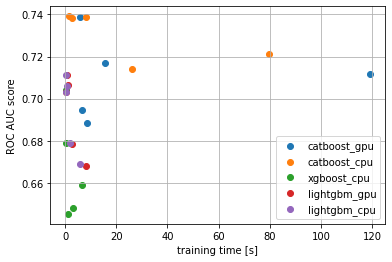

In [25]:
for model_name, result in auc_vs_time_models.items():
    points = np.array(result)
    plt.scatter(points[:, 0], points[:, 1], label=model_name)
plt.legend(loc='best')
plt.xlabel('training time [s]')
plt.ylabel('ROC AUC score')
plt.grid()

### Task 2

Write a function that selects the optimal learning rate. Early stopping is your good friend here: if a model has reached the maximum quality before hitting the iterations limit, the learning rate can be decreased, otherwise increased.

In [0]:
# xgboost
eval_set = [(X_val, y_val)]
model_xgb = xgboost.XGBClassifier(n_estimators=100500,
                                  nthread=-1,
                                  learning_rate=1.) # So that in this example it will quickly overfit
model_xgb.fit(X_train, y_train,
              verbose=False,
              eval_metric="auc", # We use that metric for final scoring
              early_stopping_rounds=10, # Try training this more rounds after reaching the best score
              eval_set=eval_set) # Note that we use separate datasets for test and early stopping
print("The trained model has only {} trees".format(len(model_xgb.get_booster().get_dump())))

In [0]:
# lightgbm
model_lgb = lightgbm.LGBMClassifier(n_estimators=100500,
                                    num_threads=-1,
                                    learning_rate=1.)
model_lgb.fit(X_train, y_train,
              verbose=False,
              eval_metric="auc",
              early_stopping_rounds=10,
              eval_set=eval_set)

print("The trained model has only {} trees".format(
      model_lgb.booster_.num_trees()))

In [0]:
# catboost
model_cb = catboost.CatBoostClassifier(n_estimators=100500,
                                       verbose=False, task_type='GPU',
                                       learning_rate=1.,
                                       # Note how unlike the other packages
                                       # eval_metric is passed to constructor
                                       # instead of fit method
                                       eval_metric="AUC")

model_cb.fit(X_train, y_train,
              verbose=False,
              early_stopping_rounds=10,
              eval_set=eval_set)
print("The trained model has only {} trees".format(
      model_cb.tree_count_))

In [0]:
# When a function gets a model in parameters, it will be reference
# it would be bad style to change it, so here is how to make a copy
from sklearn.base import clone
model_copy = clone(model_cb)

In [0]:
def find_optimal_learning_rate(model, verbose:bool=False, return_best_model:bool=False, tolerance:float=0.01):
    """
    Use early stopping and binary search to efficiently find the optimal learning rate.
    Arg:
        model: a model with sklearn-type interface
        verbose: print the progress
        return_best_model: if set, return (learning_rate, best_model)
           if not set, return just learning_rate
        tolerance: the maximum difference betweent the truly optimal and retured value
    """
    # Use eval_set for measuring the performance 
# YOUR CODE HERE
raise NotImplementedError()

In [0]:
N_TREES = 50

In [0]:
lr_xgb, clf_xgb = find_optimal_learning_rate(
    xgboost.XGBClassifier(n_estimators=N_TREES, nthread=-1), verbose=True, return_best_model=True)
print(lr_xgb)

In [0]:
lr_lgb, clf_lgb = find_optimal_learning_rate(
    lightgbm.LGBMClassifier(n_estimators=N_TREES, num_threads=-1), verbose=True, return_best_model=True)
print(lr_lgb)

In [0]:
lr_cb, clf_cb = find_optimal_learning_rate(
  catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, task_type='GPU'),
  verbose=True, return_best_model=True)
print(lr_cb)

In [0]:
evaluate_models({
        "xgb": clf_xgb,
        "lgb": clf_lgb,
        "cb": clf_cb    
    })

### Task 3 (Long and optional)
Compare the GPU and CPU performances on the whole dataset

# Ensembling - recap
* Combining several models in a semi-clever way usually results in better quality
* The most common ways are stacking, bagging and boosting
* Stacking is how deep learning works - by using the output of one model  as features to another.
* Stacking is a common thing in competititive data science, where it allows to get that 0.0001%. A common quick and dirty technique of averaging predictions of different models can be viewed as stacking with a linear model.
* Boosted decision trees have quality competitive with deep learning on tabular data. In general (please don't quote me on this), there is a trend that the smaller the datasets, the worse will a fully-connected MLP perform when compared to gradient boosting. //Tabular here means without assumptions of structure in featueres, such as when they pixels in an image. E. g. [Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS) is tabular, but ImageNet is not. You can treat any dataset as tabular, but almost certainly ignoring the structure will lead to worse performance.